# K-Means Clustering

In this notebook we would learn the premise of the k-means clustering algorithm. We'd start simple with a small image and make a 3D plot to understand, how the data points in this plot are making natural clusters.

In [78]:
from typing import Tuple, Any
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

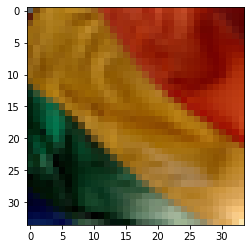

In [79]:
rainbow: np.ndarray = cv2.imread(filename='images/rainbow_icon.png')
rainbow = cv2.cvtColor(src=rainbow, code=cv2.COLOR_BGR2RGB)
plt.imshow(rainbow)

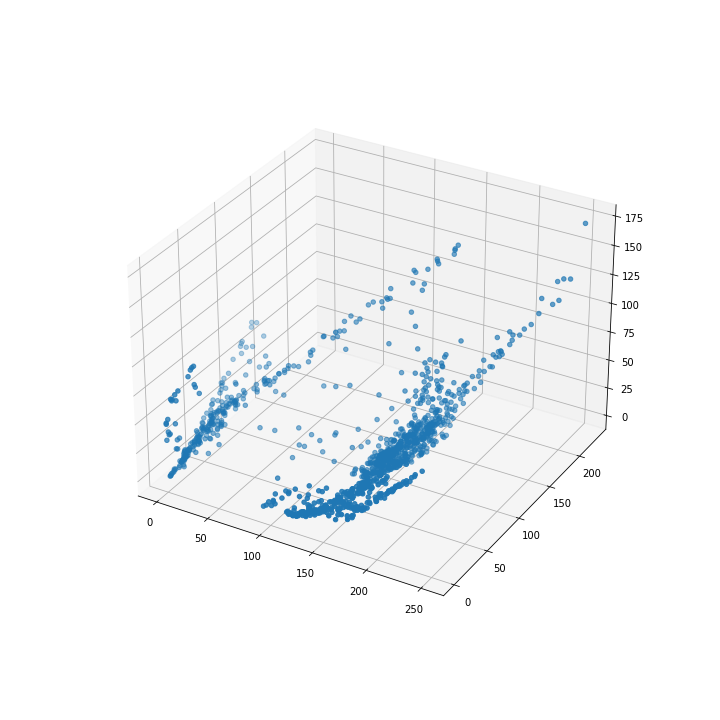

In [80]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(rainbow[:, :, 0], rainbow[:, :, 1], rainbow[:, :, 2])

The plot above should show us, that the data points are making natural clusters. This becomes an intuitive understanding, when we look at the image. We see, that the similar color pixels are closer together in the image space. And in the plot we have scattered the data points from the R, G, and B color channels. So its also natural, that data points making a similar color would also be together. That's what we see in the plot.

Now, that we can see the clusters an algorithm called `k-means` can be extremely useful in identifying these clusters separately. K-means algorithm starts with some initial estimates for the k cluster centers in the space defined by the [R, G, B] pixel intensities. Then based on he distance of each data point from these cluster centers it assigns each data point to belong to one specific cluster, identified by the respective cluster center. Then it computes the mean pixel intensity within each cluster and finally move the cluster centers for each cluster to its respective mean. This marks the end of one iterative step of the algorithm.

The algorithm runs as long as we wish it to run. There are different conventions for, when to stop. In this study we are going to stop w.r.t. a small value `epsilon`. The idea behind the same is, in each iterative step we move the cluster center by some amount to a new location. As the algorithm progresses this move amount tends to be smaller. We say, that we'd stop iterating, when the move amount has become lesser or equal to the `epsilon` value. This intuitively means, that we have reached the desired accuracy in estimating the cluster centers.

We'd make use of the following [OpenCV](https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html) utilities.

* [kmeans](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga9a34dc06c6ec9460e90860f15bcd2f88) - finds centers of the clusters and groups the input samples around the clusters. Among values it returns, $bestLabels_{i}$  contains a 0-based cluster index for the sample stored in the i'th row of the samples matrix. Following parameters are relevant for us.

    * `data` - data for clustering. An array of N-Dimensional points with float coordinates is needed. That means, we must convert the pixel intensities into float values.
    * `K` - desired number of clusters.
    * `bestLabels` - this is not useful for us since k-means is an unsupervised learning algorithm and we can not and don't want to start with some predefined labels for the data points. Hence we usually pass `None` for this.
    * `criteria` -  algorithm termination [criteria](https://docs.opencv.org/3.4/d9/d5d/classcv_1_1TermCriteria.html), that is, the maximum number of iterations and/or the desired accuracy. The accuracy is specified as criteria.epsilon. As soon as each of the cluster centers moves by less than criteria.epsilon on some iteration, the algorithm stops. This is usually passed as a tuple.
    * `attempts` - flag to specify the number of times the algorithm is executed using different initial labels. The algorithm returns the labels that yield the best compactness.
    * `flags` - how to initialize the cluster centers, [KmeansFlags](https://docs.opencv.org/4.x/d5/d38/group__core__cluster.html#ga276000efe55ee2756e0c471c7b270949).

With that, let's practice k-means clustering on some example images.

In [69]:
# Reshape the image data for convenience and convert to float type
# Here we are flatening pixel intensities for each color channel
rainbow_res: np.ndarray = np.reshape(a=rainbow, newshape=(-1, rainbow.shape[2]))
rainbow_res = np.float32(rainbow_res)

In [70]:
# The number of clusters, in which we want to break the data
k: int = 3
# The criteria for the algorithm to stop. Here we ask the algorithm to stop either on max iteration or on the epsilon value. So the algorithm should stop either after completing 10 iterations or achieving the epsilon value of 1.0, whichever is earlier.
criteria: Tuple[Any, Any, Any] = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
retval, labels, centers = cv2.kmeans(data=rainbow_res, 
                                    K=k, bestLabels=None, 
                                    criteria=criteria, 
                                    attempts=10, 
                                    flags=cv2.KMEANS_RANDOM_CENTERS)

In [71]:
# Prepare to display the data
# Convert data into uint8 values. Center denotes the determined cluster centers
centers: np.ndarray = np.uint8(centers)
segmented_data: np.ndarray = centers[labels.flatten()]
segmented_image: np.ndarray = np.reshape(a=segmented_data, newshape=rainbow.shape)

Second statement of the cell above `centers[labels.flatten()]` needs some explanation, as it may appear, that we are indexing in a smaller array with a larger array.
```python
centers.shape
# (3, 3)
centers
# array([[147,  36,   9],
#      [ 13,  48,  32],
#      [162, 114,  33]], dtype=uint8)
labels.shape
# (1156, 1)
np.unique(labels)
# array([0, 1, 2], dtype=int32)
segmented_data.shape
# (1156, 3)
```
We are indeed indexing in the aforementioned way, as it is evident from above shapes, but we need to understand, what these values are. `Centers` are cluster-centers, but they also denote mean [R, G, B] pixel intensities for respective clusters. And as we see, that the `labels` array has only three unique values, which are 0-based indices for a length of 3, which happens to be our number of desired clusters.

That means, what we are doing here is the following. When we index in the aforementioned semantical way in NumPy it invokes broadcasting. Our (3, 3) centers array is now broadcast using indices from a flattened (1156, 1) array to yield a (1156, 3) array. Intuitively in the second statement of the cell above we are creating a flattened image array, where for each pixel we are setting mean [R, G, B] intensity from the cluster, to which that pixel belongs to according to our k-means algorithm.

Finally, in third statement we are reshaping the flattened image array to have the shape of the original image, so that we can visualize the same as the segmented image. This segmented image would not look like the original image, but it is supposed to show, that our algorithm has indeed grouped the pixel intensities into three clusters.

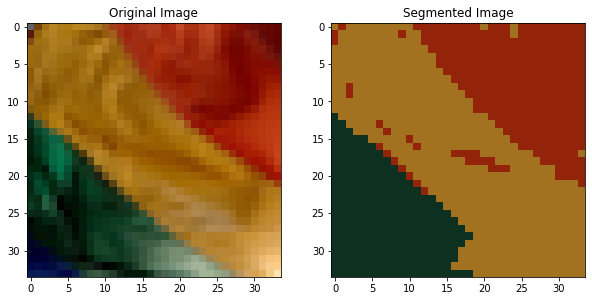

In [72]:
# Visualize the segmented image
%matplotlib inline
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax1.imshow(rainbow)
ax1.set_title('Original Image')
ax2.imshow(segmented_image)
ax2.set_title('Segmented Image');

As it is evident from above, that k-means algorithm has done an impressive job in segmenting the image. We could promisingly determine mean intensities of the three possible clusters in this image. Now we are going to look at a much more complex example, which might need some tweaking to create the optimal result, because the optimal number of clusters would not be obvious.

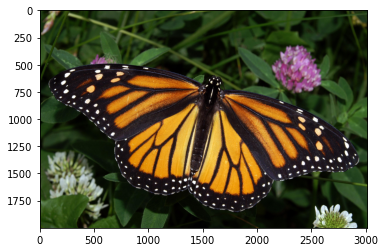

In [73]:
# Import, visualize and prepare for image segmentation
monarch: np.ndarray = cv2.imread(filename='images/monarch.jpg')
monarch = cv2.cvtColor(src=monarch, code=cv2.COLOR_BGR2RGB)
plt.imshow(monarch);

In [74]:
def segment(img: np.ndarray, num_clusters: int, epochs: int = 10, eps: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """Creates segmented image using k-means clustering. Returns segmented image and 
    labels determined by the algorithm."""
    img_res: np.ndarray = np.reshape(a=img, newshape=(-1, img.shape[2]))
    img_res = np.float32(img_res)
    criteria: Tuple[Any, Any, Any] = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, epochs, eps)
    _, labels, centers = cv2.kmeans(data=img_res, 
                                    K=num_clusters,
                                    bestLabels=None,
                                    criteria=criteria,
                                    attempts=10,
                                    flags=cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image: np.ndarray = centers[labels.flatten()]
    segmented_image = np.reshape(a=segmented_image, newshape=img.shape)
    labels_res: np.ndarray = np.reshape(a=labels, newshape=(img.shape[0], img.shape[1]))
    return segmented_image, labels_res

For the start, we are going to use number of clusters as 2.

In [75]:
k: int = 2
segmented_monarch, labels = segment(img=monarch, num_clusters=k)

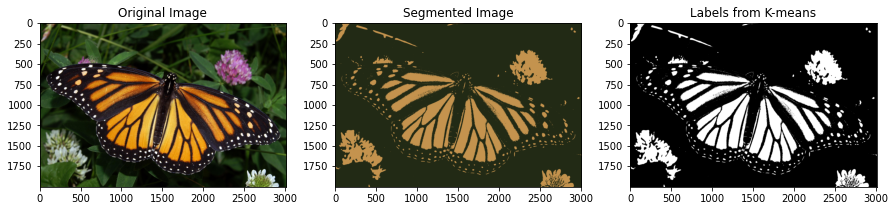

In [76]:
# Visualize the segmented image
_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax1.imshow(monarch)
ax1.set_title('Original Image')
ax2.imshow(segmented_monarch)
ax2.set_title('Segmented Image')
ax3.imshow(labels, cmap='gray')
ax3.set_title('Labels from K-means');

With the number of clusters as 2 we have separated the butterfly and some flowers almost accurately from the background. We have also extracted the labels. Let's see, what we can do with it. We need to keep in mind, that since we have selected the number of clusters as 2, we have two unique values in labels, and it is a binary image by itself.
```python
np.unique(labels)
# array([0, 1], dtype=int32)
```
Hence, it is possible for us to use the labels array as binary mask for the image. Let's see an example of the same, where we'd block the entire foreground i.e., whatever portion is labeled as 1 in this case.

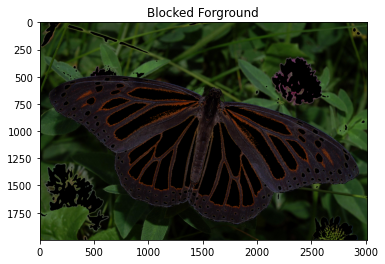

In [77]:
# Use the labels as mask
monarch_cp: np.ndarray = np.copy(monarch)
monarch_cp[labels == 1] = [0, 0, 0]
plt.imshow(monarch_cp);
plt.title('Blocked Forground');

Now let's alter the criteria also the numbers of clusters a bit to see, what kind of result we get out of that. We would now iterate 100 times and group the image in 6 clusters. This time the algorithm would take a lot more time to run.

In [81]:
k: int = 6
epochs: int = 100
eps: float = 0.2
segmented_monarch, labels = segment(img=monarch, num_clusters=k, epochs=epochs, eps=eps)

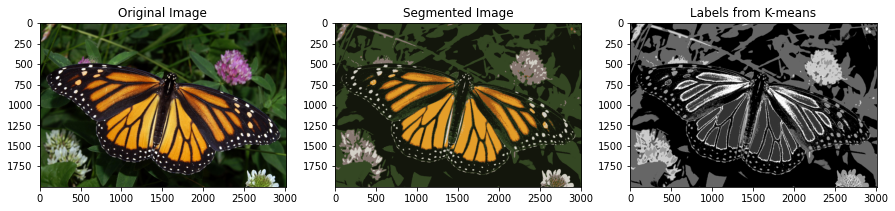

In [83]:
# Visualize the segmented image
%matplotlib inline
_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
ax1.imshow(monarch)
ax1.set_title('Original Image')
ax2.imshow(segmented_monarch)
ax2.set_title('Segmented Image')
ax3.imshow(labels, cmap='gray')
ax3.set_title('Labels from K-means');

In [84]:
print(f'Unique values in labels: {np.unique(labels)}')

Unique values in labels: [0 1 2 3 4 5]


We see, that the labels image this time has 6 indices. In the third plot above we are seeing 0 as black, 5 as white and 1-4 as different shades of gray. And the segmented image looks a lot closer to the original image, because the algorithms has found a more clusters than before, which translates to more variations of colors.

If we now try to use the labels as mask the outcome would be more subtle.

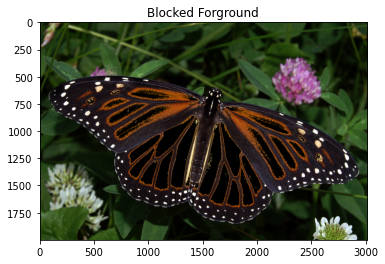

In [85]:
# Use the labels as mask
monarch_cp: np.ndarray = np.copy(monarch)
monarch_cp[labels == 1] = [0, 0, 0]
plt.imshow(monarch_cp);
plt.title('Blocked Forground');

This is expected outcome. We see, that this time with the same mask affects the image a lot less than before. We have only darkened some parts of the body of the butterfly, which the algorithm classified as a single group.